In [174]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cdist
import collections
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from wordcloud import WordCloud, get_single_color_func
from sklearn.feature_extraction.text import CountVectorizer
import random

cmap = plt.cm.Spectral
%matplotlib inline

In [268]:
def text2dict(text):
    cv = CountVectorizer(stop_words='english')
    cv_text = cv.fit_transform([text])
    return {k:v for k,v in zip(cv.get_feature_names(), cv_text.toarray().ravel())}

def topn(d, n):
    c = collections.Counter(d)
    return {k:v for k, v in c.most_common(n)}

def get_normalized_model(m, tm):
    m = np.dot(m, tm.components_)
    m-=m.mean(0)
    m-=np.min(m)
    m/=np.max(m)
    return m

class SimpleGroupedColorFunc(object):
    """Create a color function object which assigns EXACT colors
       to certain words based on the color to words mapping
       Parameters
       ----------
       color_to_words : dict(str -> list(str))
         A dictionary that maps a color to the list of words.
       default_color : str
         Color that will be assigned to a word that's not a member
         of any value from color_to_words.
    """

    def __init__(self, color_to_words, default_color):
        self.word_to_color = {word: color
                              for (color, words) in color_to_words.items()
                              for word in words}

        self.default_color = default_color

    def __call__(self, word, **kwargs):
        return self.word_to_color.get(word, self.default_color)
    
def plot_wordle(ax, textdict, maskpath=None):
    circle = np.array(Image.open(maskpath))
    wc = WordCloud(max_font_size=50, collocations=False, max_words=200, background_color="white", mask=circle, width=2000, height=1000, colormap=plt.cm.Reds)
    wc.generate_from_frequencies(textdict)
    ax.imshow(wc.recolor(color_func=grouped_color_func, random_state=3),
           interpolation="bilinear")
    ax.axis("off")
    
def plot_image(x, y, image, ax=None, zoom=1):
    if ax is None:
        ax = plt.gca()
    try:
        image = plt.imread(image)
    except TypeError:
        pass
    im = OffsetImage(image, zoom=zoom)
    x, y = np.atleast_1d(x, y)
    im.image.axes=ax
    artists = []
    ab = AnnotationBbox(im, (x, y), xycoords='data', frameon=False)
    artists.append(ax.add_artist(ab))
#     ax.update_datalim(np.column_stack([x, y]))
#     ax.autoscale()
    return artists

def add_arrows(axes, x, y, **kwargs):

    # spacing of arrows
    aspace = .05 # good value for scale of 1
    aspace *= scale

    # r is the distance spanned between pairs of points
    r = [0]
    for i in range(1,len(x)):
        dx = x[i]-x[i-1]
        dy = y[i]-y[i-1]
        r.append(np.sqrt(dx*dx+dy*dy))
    r = np.array(r)

    # rtot is a cumulative sum of r, it's used to save time
    rtot = []
    for i in range(len(r)):
        rtot.append(r[0:i].sum())
    rtot.append(r.sum())

    arrowData = [] # will hold tuples of x,y,theta for each arrow
    arrowPos = 0 # current point on walk along data
    rcount = 1 
    while arrowPos < r.sum():
        x1,x2 = x[rcount-1],x[rcount]
        y1,y2 = y[rcount-1],y[rcount]
        da = arrowPos-rtot[rcount] 
        theta = np.arctan2((x2-x1),(y2-y1))
        ax = np.sin(theta)*da+x1
        ay = np.cos(theta)*da+y1
        arrowData.append((ax,ay,theta))
        arrowPos+=aspace
        while arrowPos > rtot[rcount+1]: 
            rcount+=1
            if arrowPos > rtot[-1]:
                break

    # could be done in above block if you want
    for ax,ay,theta in arrowData:
        # use aspace as a guide for size and length of things
        # scaling factors were chosen by experimenting a bit
        axes.arrow(ax,ay,
                   np.sin(theta)*aspace/10,np.cos(theta)*aspace/10, 
                   head_width=aspace/3, **kwargs)

### Load data

In [177]:
video_events = np.load('../data/video_events.npy')
recall_events = np.load('../data/recall_events.npy')
avg_recall_events = np.load('../data/avg_recall_events.npy')
recall_embeddings = np.load('../data/embeddings.npy')[:-2]
video_embeddings = np.load('../data/video_embedding.npy')
matches = np.load('../data/labels.npy')
tm = np.load('../data/topic_model')
cv = np.load('../data/count_vectorizer_model')

### Compute distances

In [178]:
dists = []
for v in video_events:
    dist = []
    for sub in recall_events:
        dist.append(np.max(1 - cdist(np.atleast_2d(v), sub, 'correlation')))
    dists.append(dist)
dists = np.array(dists)     

### Plot the result

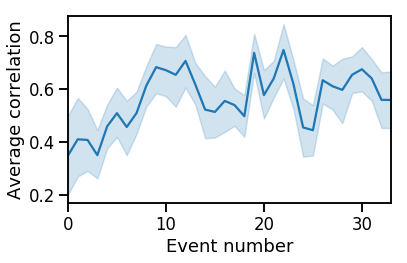

In [262]:
sns.set_context('talk')
df = pd.DataFrame(dists)
df = df.melt(var_name='subject', value_name='Average correlation')
df['Event number']=list(range(34))*17
sns.lineplot(x='Event number', y='Average correlation', data=df)
plt.tight_layout()
plt.xlim(0, 33)
plt.savefig('../figures/sme.pdf')

In [180]:
norm_video_events = get_normalized_model(video_events, tm)
norm_avg_recall_events = get_normalized_model(avg_recall_events, tm)

In [208]:
default_color = 'grey'
n=50
    
for seg in range(34):
    weights = norm_video_events[seg,:]
    textdict_video = topn({word:weight for word, weight in zip(cv.get_feature_names(), weights)}, n)
    weights = norm_avg_recall_events[seg,:]
    textdict_recall = topn({word:weight for word, weight in zip(cv.get_feature_names(), weights)}, n)

    fig, (ax1, ax2) = plt.subplots(1, 2)
    color_to_words = {'black': list(set(textdict_video))}
    grouped_color_func = SimpleGroupedColorFunc(color_to_words, default_color)
    plot_wordle(ax1, textdict_video, maskpath="../data/half-moon-left.jpg")
    color_to_words = {'black': list(set(textdict_recall))}
    grouped_color_func = SimpleGroupedColorFunc(color_to_words, default_color)
    plot_wordle(ax2, textdict_recall, maskpath="../data/half-moon.jpg")
    plt.subplots_adjust(wspace=-.5, hspace=-.5)
    fig.patch.set_visible(False)
    plt.savefig('../figures/wordle%d.png' % seg, dpi=300)
    plt.close()

### Weighted average of the event vectors by memorability

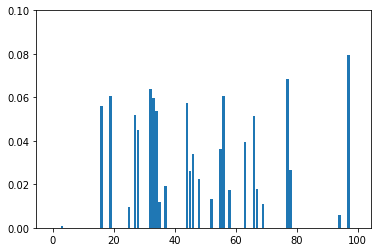

In [118]:
mdist = dists.mean(1)
rvec = np.zeros_like(video_events[0])
fvec = np.zeros_like(video_events[0])
rsum=0
fsum=0
for v, w in zip(video_events, mdist):
    rvec+=v*w
    rsum+=w
    fvec+=v*(1-w)
    fsum+=(1-w)
ax1 = plt.bar(range(100), rvec/rsum)
plt.ylim(0, .1)
plt.show()
r = rvec/rsum
r = r - video_events.mean(0)
f = fvec/fsum
f = f - video_events.mean(0)

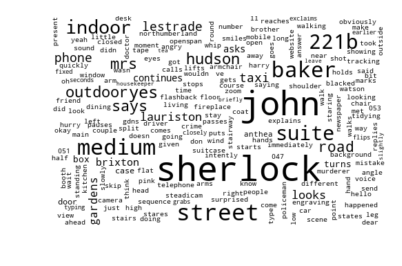

In [270]:
rweights = np.dot(r, tm.components_)
rdict = topn({word:weight for word, weight in zip(cv.get_feature_names(), rweights)}, 200)
fig, ax1 = plt.subplots(1, 1)
color_to_words = {'black': list(set(rdict))}
grouped_color_func = SimpleGroupedColorFunc(color_to_words, default_color)
plot_wordle(ax1, rdict, maskpath="../figures/oval2.jpg")
# fig.patch.set_visible(False)
plt.savefig('../figures/wordle_r.png', dpi=300)

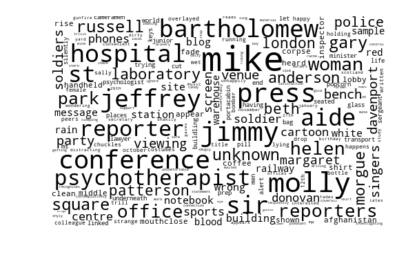

In [271]:
fweights = np.dot(f, tm.components_)
fdict = topn({word:weight for word, weight in zip(cv.get_feature_names(), fweights)}, 200)
fig, ax1 = plt.subplots(1, 1)
color_to_words = {'black': list(set(fdict))}
grouped_color_func = SimpleGroupedColorFunc(color_to_words, default_color)
plot_wordle(ax1, fdict, maskpath="../figures/oval2.jpg")
plt.savefig('../figures/wordle_f.png', dpi=300)

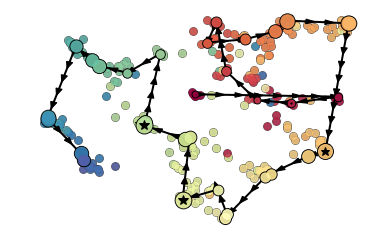

In [207]:
c = cmap(np.linspace(0, 1, 10))
sub_color = cmap(np.linspace(0, 1, 17))
subj_points = np.vstack(recall_embeddings)
fig = plt.figure()
ax = fig.add_subplot(111)
scale=10
for i, (sub, sub_match) in enumerate(zip(recall_embeddings, matches)):
    for j, (p, m) in enumerate(zip(sub, sub_match)):
        ax.plot(p[0], p[1], 'o', c=cmap(m/34), alpha=.75, zorder=2, markersize=7)
        ax.plot(p[0], p[1], 'o', c='k', alpha=.5, zorder=1, markersize=8)
hinges = video_embeddings
for i in range(len(hinges)-1):
    ax.plot([hinges[i, 0], hinges[i+1, 0]], [hinges[i, 1], hinges[i+1, 1]], c='k', linewidth=2, alpha=1)
for i in range(len(hinges)):
    ax.plot(hinges[i,0], hinges[i,1], 'o', c=cmap(i/34), zorder=4, markersize=mdist[i]*scale+5, alpha=.9)
    ax.plot(hinges[i,0], hinges[i,1], 'ko', zorder=3, markersize=mdist[i]*scale+7, alpha=.9)
    if i in np.argsort(mdist)[-3:]:
        ax.plot(hinges[i,0], hinges[i,1], 'k*', zorder=5, markersize=mdist[i]*scale)
    if i in np.argsort(mdist)[:3]:
        ax.plot(hinges[i,0], hinges[i,1], 'k*', zorder=5, markersize=mdist[i]*scale)
add_arrows(ax, hinges[:, 0], hinges[:, 1], zorder=3, alpha=1, color='k', fill=True)
ax.axis('off')
plt.savefig('../figures/gist2.pdf')
plt.show()

In [209]:
np.argsort(mdist)[-3:]

array([12, 19, 22])